In [111]:
import pandas as pd
import numpy as np
import multiprocessing as mp
np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap 

import causalml
from causalml.metrics import plot_gain, plot_qini, qini_score
from causalml.dataset import synthetic_data
from causalml.inference.tree import plot_dist_tree_leaves_values, get_tree_leaves_mask
from causalml.inference.tree import CausalRandomForestRegressor, CausalTreeRegressor
from causalml.inference.tree.utils import timeit

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [129]:
df = pd.read_csv('../../data/acoustic_and_session.csv')

In [130]:
cols1 = [ 'hour_of_day', 'session_position', 'premium', 'session_length','hist_user_behavior_is_shuffle', 'custom_skip',
 'duration', 'release_year', 'us_popularity_estimate',
       'acousticness', 'beat_strength', 'bounciness', 'danceability',
       'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mechanism', 'mode', 'organism', 'speechiness',
       'tempo', 'time_signature', 'valence', 'acoustic_vector_0',
       'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
       'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6',
       'acoustic_vector_7'] 
df["mode"] = df.apply(lambda x:1 if x["mode"]=="major"else 0, axis = 1)

df1 = df[cols1]
for col in cols1:
    if df[col].dtype ==bool:
      df1[col] = df1[col].astype(int)
df1.rename(columns={'hist_user_behavior_is_shuffle':'shuffle'},inplace =True)



In [131]:
df_train, df_test = train_test_split(df1, test_size=0.2, random_state=111)

In [132]:
feature_names = [ 'hour_of_day', 'session_position', 'premium', 'session_length','shuffle',
  'release_year', 'us_popularity_estimate',
       'acousticness', 'beat_strength', 'bounciness', 'danceability',
       'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mechanism', 'mode', 'organism', 'speechiness',
       'tempo', 'time_signature', 'valence', 'acoustic_vector_0',
       'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
       'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6',
       'acoustic_vector_7'] 
treatment = ['duration']

In [133]:
X_train, y_train = df_train[feature_names], df_train['custom_skip'].values
X_test, y_test = df_test[feature_names], df_test['custom_skip'].values
treatment_train, treatment_test = df_train[treatment].values.flatten(), df_test[treatment].values.flatten()

In [134]:
treatment_train

array([262.54666138, 194.67999268, 182.72000122, ..., 275.21786499,
       167.29818726, 239.69332886])

In [135]:
ctree = CausalTreeRegressor(control_name=100)
ctree.fit(X=X_train.values, y=y_train, treatment=treatment_train)

CausalTreeRegressor(control_name=100)

In [103]:
# crforest = CausalRandomForestRegressor(criterion="causal_mse",
#                                   min_samples_leaf=200,
#                                   control_name=0,
#                                   n_estimators=10,
#                                   n_jobs=mp.cpu_count() - 1)
# crforest.fit(X=X_train.values, y=y_train, treatment=treatment_train)

CausalRandomForestRegressor(min_samples_leaf=200, n_estimators=10, n_jobs=7)

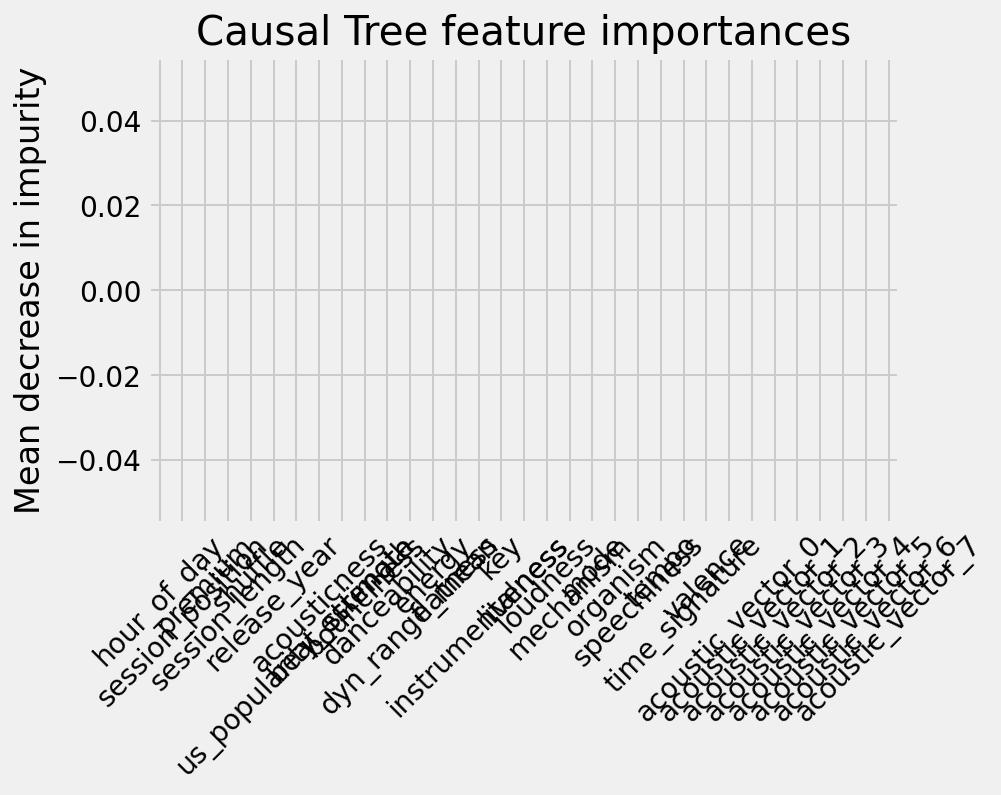

In [137]:
df_importances = pd.DataFrame({'tree': ctree.feature_importances_, 
                            #    'forest': crforest.feature_importances_,
                               'feature': feature_names
                              })
forest_std = np.std([tree.feature_importances_ for tree in crforest.estimators_], axis=0)

fig, ax = plt.subplots()
df_importances['tree'].plot.bar(ax=ax)
ax.set_title("Causal Tree feature importances")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feature_names, rotation=45)
plt.show()

# fig, ax = plt.subplots()
# df_importances['forest'].plot.bar(yerr=forest_std, ax=ax)
# ax.set_title("Causal Forest feature importances")
# ax.set_ylabel("Mean decrease in impurity")
# ax.set_xticklabels(feature_names, rotation=45)
# plt.show()

In [138]:
ctree.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

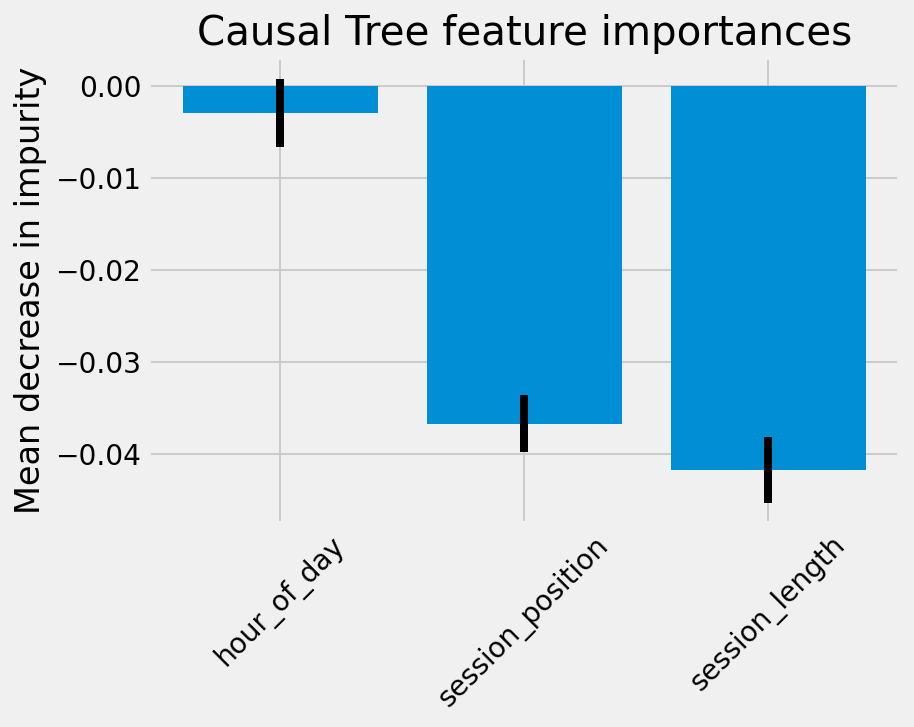

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
for name, model in zip(('Causal Tree'), (ctree)):
    
    imp = permutation_importance(model, X_test, y_test,
                                 n_repeats=50,
                                 random_state=0)
    
    fig, ax = plt.subplots()
    ax.set_title(f"{name} feature importances")
    ax.set_ylabel("Mean decrease in impurity")
    plt.bar(feature_names, imp['importances_mean'], yerr=imp['importances_std'])
    ax.set_xticklabels(feature_names, rotation=45)
    plt.show()

In [ ]:
observation = X_test.iloc[0]
tree_explainer = shap.TreeExplainer(ctree)
shap_values = tree_explainer.shap_values(observation)
shap.force_plot(tree_explainer.expected_value[0],
                shap_values,
                observation)

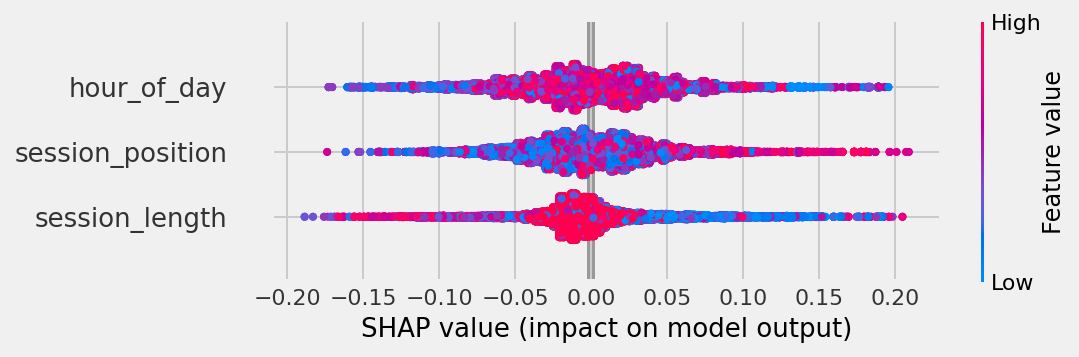

In [110]:
shap.summary_plot(tree_explainer.shap_values(X_test), X_test)